Populating the interactive namespace from numpy and matplotlib
1.10.4
2.1.0
0.20.3
0.8.0
          PL Intensity (kCts/s)
Time (s)                       
0.01                       36.9
0.02                       34.9
0.03                       36.9
0.04                       37.5
0.05                       35.8


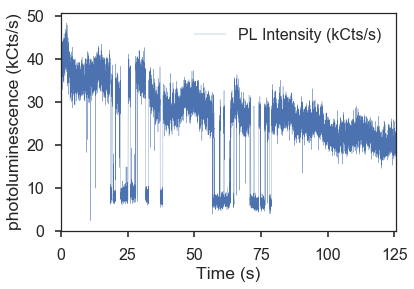

today: 2018-07-02


'O:\\User\\Viva\\analysis\\blinker_analysis\\taken-2018-05-25'

In [47]:
# -*- coding: utf-8 -*-
"""
Created on Sun May 27 17:17:43 2018

Blinker analysis

@author: Viva Horowitz
"""

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import os
import datetime
import seaborn as sns
import numpy as np
sns.set(style='ticks')
sns.set_context('poster')
from __future__ import division # division should return float

%pylab inline

print(np.__version__)
print(mpl.__version__)
print(pd.__version__)
print(sns.__version__)

# ** set for each dataset
datadate = '2018-05-25'
datafolder = r'O:\User\Viva\data\2018-05-25_blinking-statistics'
filename = 'GoodBlinker_5-25-2018.txt'
analysisfolder = r'O:\User\Viva\analysis\blinker_analysis'

os.chdir(datafolder)

tname = 'Time (s)'
PLname = 'PL Intensity (kCts/s)'
data = pd.read_csv(filename,
                   skiprows=1,
                   header=None,
                   sep='\t',
                   names=['Time (s)','PL Intensity (kCts/s)'],
                   usecols=[0,1])
data = data.set_index(tname)
print(data.head())
rebincount = 0

data.plot(linewidth=0.3)
plt.ylabel('photoluminescence (kCts/s)')
plt.show()

filename = filename.replace('\\','-')
origfilename = filename
os.chdir(analysisfolder)
today = datetime.date.isoformat(datetime.date.today())
if not os.path.exists('taken-' + datadate):
    os.makedirs('taken-' + datadate)
os.chdir('taken-' + datadate)

print('today: '+today)
os.getcwd()

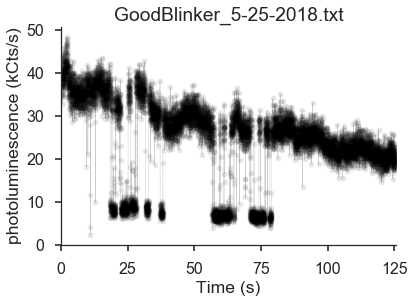

Collection rate: 100.0 Hz
Time bin size: 0.01 sec


In [2]:
fig1,axPL = plt.subplots()
#axPL.plot(data, 'k')
#axPL.legend.remove()
data.plot(marker='.',linestyle='None',legend=False, ax=axPL, color='k',  alpha=.1)
data.plot(legend=False, linewidth=0.5, alpha=0.2, ax=axPL, color='k')
plt.ylabel('photoluminescence (kCts/s)')
plt.xlabel(tname)

plt.title(filename)

sns.despine()
plt.savefig(today + ',' + filename+',blinking.pdf', bbox_inches='tight')
plt.savefig(today + ',' + filename+',blinking.png', bbox_inches='tight', dpi=200)

plt.show()

def arangebylength(start, step, length):
    return np.arange(start = start, stop=start+step*(length-.5), step = step )

# rebin: combine two rows into one.
def rebindata(data, colname=PLname, indexname = tname):
    first = 1 # this is a value that indicates if we're on the first (=1) or the second (-1) of a pair of two bins
    rebinvals = []

    for value in data[colname]:
        if first == 1:
            prevval = value
        else:
            # calculate average of the two bins
            combined = (prevval + value) /2.0 
            rebinvals.append(combined)
            del prevval
        first = -1 * first
        
    timesetting = data.index[1]-data.index[0]
    rebintimes = arangebylength(start =0, step = timesetting*2, length = len(rebinvals) )
    rebinneddata = pd.DataFrame(data = rebinvals, index = rebintimes, columns =[colname])
    rebinneddata.index.name=indexname
    return rebinneddata

# The data was collected at a particular rate
timesetting = data.index[1]-data.index[0]
fps = 1/timesetting
print('Collection rate: ' + str(fps) + ' Hz')
print('Time bin size: ' + str(timesetting) + ' sec')

Effective collection rate: 100.0 Hz
Time bin size: 0.01 sec


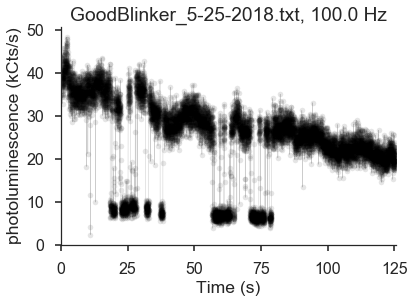

In [3]:
# *** run this an appropriate number of times, can skip if not rebinning

n = 0 # number of times to rebin.

for i in range(n):
    data = rebindata(data)
    rebincount = rebincount + 1
    print(rebincount)

timesetting = data.index[1]-data.index[0]
fps = 1/timesetting
print('Effective collection rate: ' + str(fps) + ' Hz')
print('Time bin size: ' + str(timesetting) + ' sec')
filename = origfilename + ', ' + str(fps) + ' Hz'


fig1,axPL = plt.subplots()
#axPL.plot(data, 'k')
#axPL.legend.remove()
data.plot(marker='.',linestyle='None',legend=False, ax=axPL, color='k',  alpha=.1)
data.plot(legend=False, linewidth=0.5, alpha=0.2, ax=axPL, color='k')
plt.ylabel('photoluminescence (kCts/s)')
plt.xlabel(tname)

plt.title(filename)

sns.despine()
#plt.savefig(today + ',' + filename+',blinking.pdf', bbox_inches='tight')
#plt.savefig(today + ',' + filename+',blinking.png', bbox_inches='tight', dpi=200)

plt.show()

93 bins


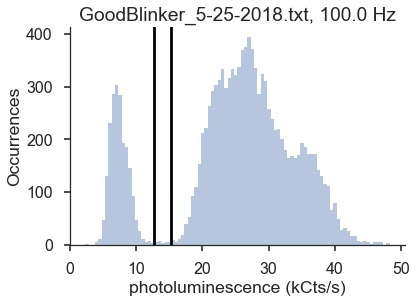

In [4]:
binsequence = np.arange(data.min(), data.max(), fps/200)# ** adjust bins as needed. Higher denominator: more bins
print (str(len(binsequence)) + ' bins')

#data.hist(bins= binsequence)
sns.distplot(data, bins=binsequence, kde=False, rug=False, kde_kws={'bw':.5, 'label':'KDE'}, norm_hist=False); # must norm if KDE
plt.xlabel('photoluminescence (kCts/s)')
#plt.locator_params(axis='x', nbins=10)
ax = plt.gca()

# ** Need to pick an appropriate threshold between on and off for each dataset
uthreshold = 15.2
lthreshold = uthreshold-2.5

ax.axvline(x=uthreshold, color='k')
ax.axvline(x=lthreshold, color = 'k')
#ax.tick_params(axis='x',which='minor',bottom='on')
#ax.xaxis.set_minor_locator(minorLocator)

plt.title(filename)
plt.ylabel('Occurrences')
sns.despine()

#plt.savefig(today + ',' + filename+',PLhistogram.pdf', bbox_inches='tight')
#plt.savefig(today + ',' + filename+',PLhistogram.png', bbox_inches='tight', dpi=200)

plt.show()

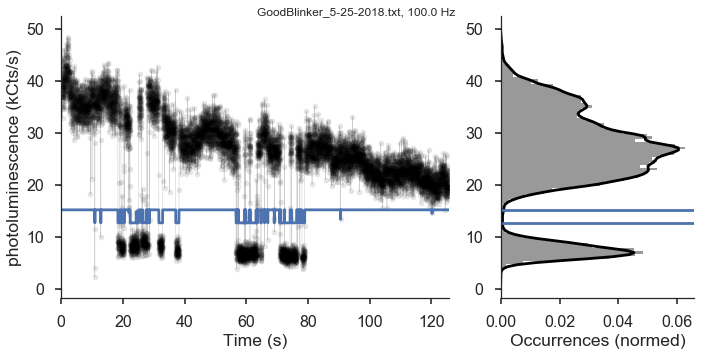

In [5]:
# With an uthreshold and an lthreshold
# This code has an in between status where it won't be counted as remaining in the state 
# but it won't be counted in the other state, either. 
# This seems like the most straightforward way to deal with (rare) cases in between.
# Other options are shown.


threshdata = data[PLname].clip(upper=uthreshold, lower=lthreshold)


fig2,[axPL,axhist] = plt.subplots(nrows=1, ncols=2, figsize=(10,5), sharey=True, gridspec_kw = {'width_ratios':[4,2]})
data.plot(marker='.',linestyle='None',legend=False, alpha=0.1, ax=axPL, color='k')
data.plot(legend=False, linewidth=0.5, alpha=0.2, ax=axPL, color='k')
threshdata.plot(legend=False, ax=axPL)
axPL.set_ylabel('photoluminescence (kCts/s)')
axPL.set_xlabel(tname)
plt.suptitle(filename)
sns.despine()
plt.tight_layout() 

sns.distplot(data, bins=binsequence, kde=True, rug=False, ax=axhist, vertical=True, color='k',
             kde_kws={'bw':.5});
#             kde_kws={'bw':.5, 'label':'Kernal density\nestimate (KDE)'});
#axhist.set_xlabel('photoluminescence (kCts/s)')
axhist.set_xlabel('Occurrences (normed)')
axhist.axhline(y=uthreshold)
axhist.axhline(y=lthreshold)

plt.savefig(today + ',' + filename+',blinkingandthreshold.pdf', bbox_inches='tight')
plt.savefig(today + ',' + filename+',blinkingandthreshold.png', bbox_inches='tight', dpi=200)

plt.show();

In [77]:
# Main method: in between status where it won't be counted as remaining in the state 
# but it won't be counted in the other state, either.
downtimes2= threshdata[threshdata != uthreshold].index
uptimes2=threshdata[threshdata != lthreshold].index

#print(uptimes2)
#print(downtimes2)

# Alternate option (not used)
uptimes= threshdata[threshdata == uthreshold].index
downtimes=threshdata[threshdata == lthreshold].index

#print(uptimes)
#print(downtimes)

# We can compare the two ways of interpreting blinks.
# There is a discrepancy at about 22 seconds between the two interpretations. 
# It's a matter of whether we consider it stayed off or 
# if we consider that it came up enough to have ended the off blink and began another.
# I tend to think it ended one and began another in this case, so I'm going to use uptimesep2 as my off duration.

# subtracting each time from the last time we had the same state gives the amount of time it was not in that state.
# Therefore the separation between up times is in fact the duration of time off.
uptimesep = uptimes[1:] - uptimes[:-1]
uptimesep2 = uptimes2[1:] - uptimes2[:-1]

"""
plt.plot(uptimes[:-1],uptimesep, '.-')
plt.plot(uptimes2[:-1],uptimesep2, '-')
plt.ylim(ymin=3*timesetting)
#plt.axis('equal')
plt.xlabel(tname)
plt.ylabel('duration of blink off (s)')
plt.figure()
data.plot()
plt.show()
"""

# We can compare the two ways of interpreting blinks. It looks like they mostly agree.

downtimesep = downtimes[1:] - downtimes[:-1]
downtimesep2 = downtimes2[1:] - downtimes2[:-1]

"""
plt.plot(downtimes[:-1],downtimesep,'.-')
plt.plot(downtimes2[:-1],downtimesep2,'-')
plt.ylim(ymin=3*timesetting)
#plt.axis('equal')
plt.xlabel(tname)
plt.ylabel('duration of blink on (s)')
#plt.figure()
data.plot()
plt.show()
"""

# I chose to use downtimesep2 and uptimesep2, as detailed above.

ontimes = filter(lambda a: a > 1.5*timesetting, downtimesep2)
offtimes = filter(lambda a: a > 1.5*timesetting, uptimesep2)

# save analyzed data: bright state duration
ontimesdf = pd.DataFrame(ontimes, columns=["Bright state duration (s)"])
ontimesdf.to_csv(filename+' uptimes.csv', index=False, header=True)
print('Uptimes saved to: ')
print(os.path.join(os.getcwd(), filename+ ' uptimes.csv'))
# save analyzed data: dim state duration
offtimesdf = pd.DataFrame(offtimes, columns=["Dim state duration (s)"])
offtimesdf.to_csv(filename+' downtimes.csv', index=False, header=True)
print('Downtimes saved to: ')
print(os.path.join(os.getcwd(), filename+ ' downtimes.csv'))
## to open: 
# ontimesdf = pd.read_csv(filename+' ontimes.csv'
# offtimesdf = pd.read_csv(filename+' downtimes.csv')
#  # convert to list or else the rest of the code won't work.
# ontimes = list(ontimesdf['Bright state duration (s)'])
# offtimes = list(offtimesdf["Dim state duration (s)"])

## https://stackoverflow.com/questions/32765333/how-do-i-replicate-this-matlab-function-in-numpy/32765547#32765547
def histc(X, bins):
    map_to_bins = np.digitize(X,bins)
    r = np.zeros(bins.shape)
    for i in map_to_bins:
        r[i-1] += 1
    return [r, map_to_bins]

def CDF(S):
    M = len(S); # size of array = number of elements
    sorteddata = sort(S); # ascending sort is CDF, descending sort is 1-CDF
    cum_prob = [elem/M for elem in range(M)] # probability integrated from 0 to sorteddata.
    cum_prob2 = [1-p for p in cum_prob] # probability integrated from sorteddata to inf
    return sorteddata,cum_prob2

def nonlinearhistc(X,bins, thresh=3, verbose = True):
    map_to_bins = np.digitize(X,bins)
    r = np.zeros(bins.shape)
    for i in map_to_bins:
        r[i-1] += 1
    if verbose:
        print r 
        #print bins
    ## normalize by bin width
    probability = np.zeros(bins.shape)
    area = 0;
    thinbincount = 0
    for i in range(len(bins)-1):
        if r[i]<=1:
            thinbincount += 1;
        thisbinwidth = bins[i+1] - bins[i]
        probability[i] = r[i]/thisbinwidth
        area += probability[i]*thisbinwidth;
        
    if thinbincount > thresh:
        print("Warning: too many bins for data, thinbincount=" + str(thinbincount))
    elif verbose:
        print("thinbincount=" + str(thinbincount))
    ## normalize area.
    normedprobability = [eachprobability / area for eachprobability in probability]
    return normedprobability, map_to_bins

Uptimes saved to: 
O:\User\Viva\analysis\blinker_analysis\taken-2018-05-25\GoodBlinker_5-25-2018.txt uptimes.csv
Downtimes saved to: 
O:\User\Viva\analysis\blinker_analysis\taken-2018-05-25\GoodBlinker_5-25-2018.txt downtimes.csv


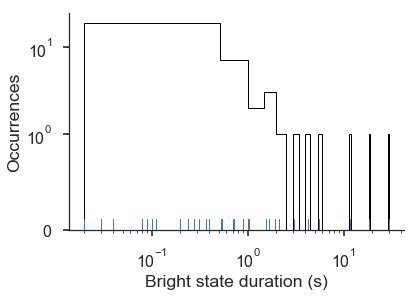

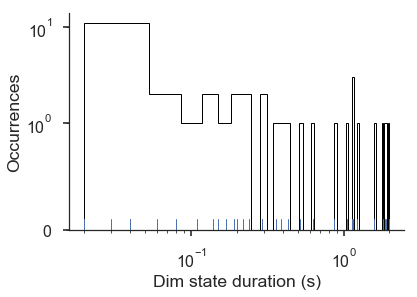

In [7]:
# ** Choose a nice number of bins to see how the data look.
# It's better to have as many bins as possible before the first empty bin.

numonbins = 60
numoffbins = 60

#plt.hist(ontimes, bins=numonbins, histtype='step', linewidth=1)
sns.distplot(ontimes, bins=numonbins, kde=False, rug=True, 
             hist_kws={"histtype": "step", "linewidth": 1, "alpha": 1, "color": "k"});
plt.xlabel('Bright state duration (s)')
plt.ylabel('Occurrences')
ax = plt.gca()
ax.set_yscale('symlog', linthreshy=1)
ax.set_xscale('log')
sns.despine()
plt.show()
#plt.hist(offtimes, bins=numoffbins, histtype='step', linewidth=1)
sns.distplot(offtimes, bins=numoffbins, kde=False, rug=True, 
             hist_kws={"histtype": "step", "linewidth": 1, "alpha": 1, "color": "k"});
plt.xlabel('Dim state duration (s)')
plt.ylabel('Occurrences')
ax = plt.gca()
ax.set_yscale('symlog', linthreshy=1)
ax.set_xscale('log')
sns.despine()
plt.show()

[ 9.  3.  2.  5.  9.  4.  3.  1.  2.  0.]
thinbincount=1
[ 8.  3.  2.  3.  5.  4.  3.  5.  6.  0.]
thinbincount=0


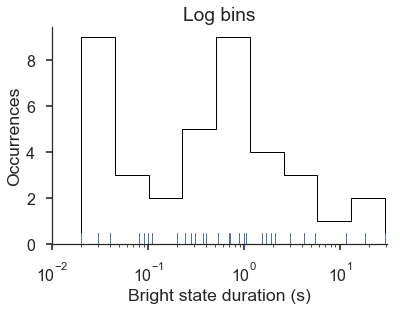

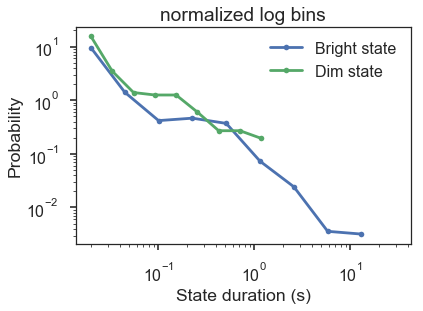

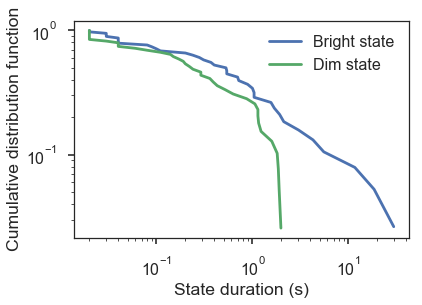

In [89]:
# logarithmic bins.

small = 1e-4

numonbins_log = 10
numoffbins_log = 10

onbins=np.logspace(np.log10(min(ontimes)-small),np.log10(max(ontimes)+small), numonbins_log)
offbins = np.logspace(np.log10(min(offtimes)-small),np.log10(max(offtimes)+small), numoffbins_log)

onfitx = np.logspace(np.log10(min(ontimes)),np.log10(max(ontimes)), numonbins_log*10)
offfitx = np.logspace(np.log10(min(offtimes)),np.log10(max(offtimes)), numoffbins_log*10)

#plt.hist(ontimes, bins=numonbins, histtype='step', linewidth=1)
sns.distplot(ontimes, bins=onbins, kde=False, rug=True, 
             hist_kws={"histtype": "step", "linewidth": 1, "alpha": 1, "color": "k"});
plt.xlabel('Bright state duration (s)')
plt.ylabel('Occurrences')
ax = plt.gca()
xlim(xmin=1e-2)
#ax.set_yscale('symlog', linthreshy=1)
ax.set_xscale('log')
sns.despine()
title('Log bins' )

onprobs, _ = nonlinearhistc(ontimes, onbins) 
offprobs, _ = nonlinearhistc(offtimes, offbins)     
    
plt.figure()
plot(onbins,onprobs, '.-', label="Bright state");
plot(offbins,offprobs, '.-', label="Dim state");

gca().set_yscale('log')
gca().set_xscale('log')
title('normalized log bins')
plt.xlabel('State duration (s)')
plt.ylabel('Probability');
legend();

figure()
sortedontimes,CDFontimes=CDF(ontimes)
sortedofftimes,CDFofftimes=CDF(offtimes)
loglog(sortedontimes,CDFontimes, label='Bright state');
loglog(sortedofftimes,CDFofftimes, label='Dim state');
xlabel('State duration (s)');
ylabel('Cumulative distribution function');
legend();

In [90]:
from scipy.optimize import curve_fit
import scipy
print(scipy.__version__)
# need at least version 14.0 of scipy.

def expfit(t, A, tau):
    return (A * np.exp(t/(-tau)))

def powlaw(t, C, m):
    return C * t**(-m)

def CDFpowlaw(t,C,m):
    return (C/(m-1)) * t**(-(m-1)) # https://arxiv.org/pdf/cond-mat/0412004.pdf

# Trying to find good guess
#onparamexp[1]=-.8
#onfitexp = 30 * np.exp(centeredonbins/(onparamexp[1]))

0.17.1


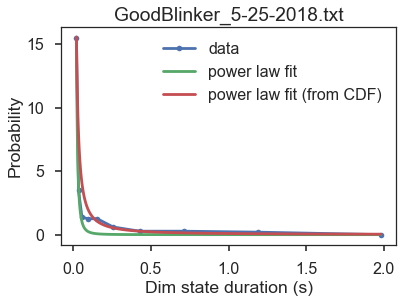

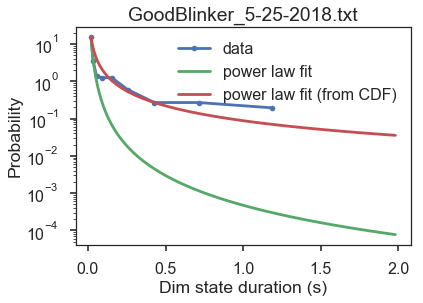

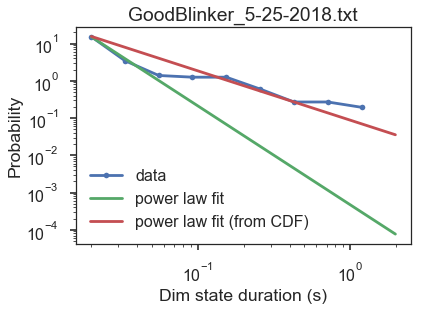

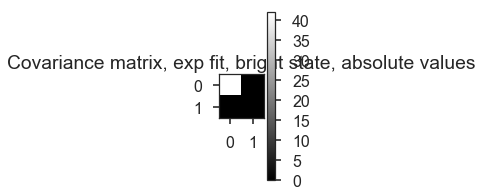

It's ok to use the uncertainties below as long as there aren't strong on-diagonal values.


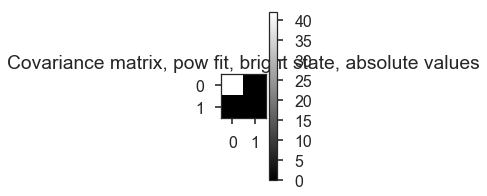

It's ok to use the uncertainties below as long as there aren't strong on-diagonal values.
Exponential fit:
on Coefficient A_bright = 43.2624449175 ± 6.48055438454
time constant tau_bright = 0.0131303198989 ± 0.00124328987187 sec
Power law:
on Coefficient C_bright = 0.00129556030877 ± 0.000845790015739
logarithmic slope m_bright = 2.27207987345 ± 0.167447996696


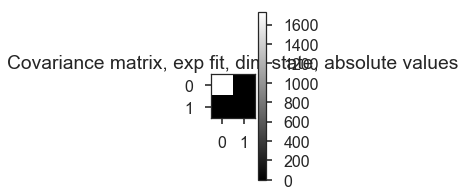

It's ok to use the uncertainties below as long as there aren't strong off-diagonal values.


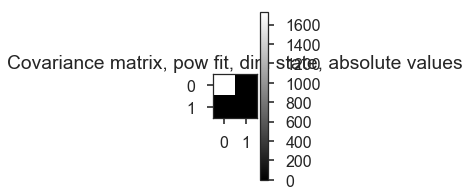

It's ok to use the uncertainties below as long as there aren't strong off-diagonal values.
Exponential fit:
off Coefficient A_dim = 128.149292338 ± 41.5486561768
time constant tau_dim = 0.00939423437078 ± 0.00136924540594 sec
Power law:
off Coefficient C_dim = 0.000469026176813 ± 0.000519278146914
logarithmic slope m_dim = 2.65442276851 ± 0.285071173553


In [92]:
showexpfit = False
showpowfit = True

### ==== FITS ====

# on time exponential fit, not truncated
onparamexp, onpcovexp = curve_fit(expfit, onbins, onprobs,p0 = (30, 2))
onfitexp = expfit(onfitx,onparamexp[0],onparamexp[1])

# on time power law fit, not truncated
onparampow, onpcovpow = curve_fit(powlaw, onbins, onprobs,p0 = (2, 1))
onfitpow = powlaw(onfitx,onparampow[0],onparampow[1])

# off time exponential fit, not truncated
offparamexp, offpcovexp = curve_fit(expfit, offbins, offprobs,p0 = (30, 2))
offfitexp = expfit(offfitx,offparamexp[0],offparamexp[1])

# off time power law fit, not truncated
offparampow, offpcovpow = curve_fit(powlaw, offbins, offprobs,p0 = (2, 1))
offfitpow = powlaw(offfitx,offparampow[0],offparampow[1])

# off time power law fit to CDF
offparampow_fromCDF, offpcovpowCDF = curve_fit(CDFpowlaw, sortedofftimes,CDFofftimes,p0 = offparampow)
offfitpow_fromCDF = powlaw(offfitx,offparampow_fromCDF[0],offparampow_fromCDF[1])
offfitpowCDF = CDFpowlaw(offfitx,offparampow_fromCDF[0],offparampow_fromCDF[1])

### ===  display fits ===

fig,ax1 = plt.subplots()
ax1.plot(offbins,offprobs,'.-', label='data')
plt.xlabel('Dim state duration (s)')
plt.ylabel('Probability')
#ax1.set_yscale('symlog', linthreshy=1)
if showexpfit:
    ax1.plot(offfitx,offfitexp, label='exponential fit')
if showpowfit:
    ax1.plot(offfitx, offfitpow, label= 'power law fit')
    ax1.plot(offfitx, offfitpow_fromCDF, label= 'power law fit (from CDF)')
plt.title(filename)
plt.legend()
plt.show()

fig,ax1 = plt.subplots()
ax1.plot(offbins,offprobs,'.-', label='data')
plt.xlabel('Dim state duration (s)')
plt.ylabel('Probability')
#ax1.set_yscale('symlog', linthreshy=1)
if showexpfit:
    ax1.plot(offfitx,offfitexp, label='exponential fit')
if showpowfit:
    ax1.plot(offfitx, offfitpow, label= 'power law fit')
    ax1.plot(offfitx, offfitpow_fromCDF, label= 'power law fit (from CDF)')
plt.title(filename)
plt.legend()
ax1.set_yscale('log', linthreshy=1)
plt.show()

fig,ax1 = plt.subplots()
ax1.plot(offbins,offprobs,'.-', label='data')
plt.xlabel('Dim state duration (s)')
plt.ylabel('Probability')
#ax1.set_yscale('log')
if showexpfit:
    ax1.plot(offfitx,offfitexp, label='exponential fit')
if showpowfit:
    ax1.plot(offfitx, offfitpow, label= 'power law fit')
    ax1.plot(offfitx, offfitpow_fromCDF, label= 'power law fit (from CDF)')
plt.title(filename)
plt.legend()
ax1.set_yscale('log')
ax1.set_xscale('log')
plt.show()


# === BRIGHT STATE fit params ===
figure(figsize=(1,6))
plt.imshow(abs(onpcovexp), cmap="gray", interpolation="nearest", vmin=0)
plt.colorbar()
plt.title('Covariance matrix, exp fit, bright state, absolute values')
plt.show()
print("It's ok to use the uncertainties below as long as there aren't strong on-diagonal values.")

figure(figsize=(1,6))
plt.imshow(abs(onpcovexp), cmap="gray", interpolation="nearest", vmin=0)
plt.colorbar()
plt.title('Covariance matrix, pow fit, bright state, absolute values')
plt.show()
print("It's ok to use the uncertainties below as long as there aren't strong on-diagonal values.")

print 'Exponential fit:'
print  'on Coefficient A_bright = ' + str(onparamexp[0]) + ' ± ' + str(np.sqrt(onpcovexp[0,0]))
print 'time constant tau_bright = ' + str(onparamexp[1]) + ' ± ' + str(np.sqrt(onpcovexp[1,1])) + ' sec'

print 'Power law:'
print  'on Coefficient C_bright = ' + str(onparampow[0]) + ' ± ' + str(np.sqrt(onpcovpow[0,0]))
print 'logarithmic slope m_bright = ' + str(onparampow[1]) + ' ± ' + str(np.sqrt(onpcovpow[1,1]))


# === DIM STATE fit params ===
figure(figsize=(1,6))
plt.imshow(abs(offpcovexp), cmap="gray", interpolation="nearest", vmin=0)
plt.colorbar()
plt.title('Covariance matrix, exp fit, dim state, absolute values')
plt.show()
print("It's ok to use the uncertainties below as long as there aren't strong off-diagonal values.")

figure(figsize=(1,6))
plt.imshow(abs(offpcovexp), cmap="gray", interpolation="nearest", vmin=0)
plt.colorbar()
plt.title('Covariance matrix, pow fit, dim state, absolute values')
plt.show()
print("It's ok to use the uncertainties below as long as there aren't strong off-diagonal values.")

print 'Exponential fit:'
print  'off Coefficient A_dim = ' + str(offparamexp[0]) + ' ± ' + str(np.sqrt(offpcovexp[0,0]))
print 'time constant tau_dim = ' + str(offparamexp[1]) + ' ± ' + str(np.sqrt(offpcovexp[1,1])) + ' sec'

print 'Power law:'
print  'off Coefficient C_dim = ' + str(offparampow[0]) + ' ± ' + str(np.sqrt(offpcovpow[0,0]))
print 'logarithmic slope m_dim = ' + str(offparampow[1]) + ' ± ' + str(np.sqrt(offpcovpow[1,1]))


In [ ]:
#basefilename = today + ',' + filename+',offblinks' + infostr

def ploteveryfig(fig,ax,basefilename,fitx,powfit, save=True):
    sns.despine()
    
  #  fig.savefig(basefilename + '.pdf', bbox_inches='tight', dpi=200)
  #  fig.savefig(basefilename + '.png', bbox_inches='tight', dpi=200)

  #  ax.set_yscale('symlog', linthreshy=1)
  #  fig.savefig(basefilename + ',semisymlog.pdf', bbox_inches='tight', dpi=200)
  #  fig.savefig(basefilename + ',semisymlog.png', bbox_inches='tight', dpi=200)

    ax.set_yscale('linear')
    ax.plot(fitx, powfit, label="power law")
    ax.legend(loc=5)
    if save:
        fig.savefig(basefilename + ',powfit.pdf', bbox_inches='tight', dpi=200)
        fig.savefig(basefilename + ',powfit.png', bbox_inches='tight', dpi=200)

    ax.set_yscale('log')
    ax.legend(loc=3)
    if save:
        fig.savefig(basefilename + ',powfit,semilog.pdf', bbox_inches='tight', dpi=200)
        fig.savefig(basefilename + ',powfit,semilog.png', bbox_inches='tight', dpi=200)

    ax.set_xscale('log')
    if save:
        fig.savefig(basefilename + ',powfit,loglog.pdf', bbox_inches='tight', dpi=200)
        fig.savefig(basefilename + ',powfit,loglog.png', bbox_inches='tight', dpi=200)
    

In [ ]:
# Save figures

# mpl.rcParams['figure.dpi'] = 200

font = {'size'   : 22}
plt.rc('font', **font)

infostr = ',fitpast0'

# display off blinks
fig,ax1 = plt.subplots()
ax1.plot(offbins,offprobs,'o-')
plt.xlabel('Dim state duration (s)')
plt.ylabel('Occurrences')
#ax1.set_yscale('symlog', linthreshy=1)
ax1.plot(offfitx,offfitexp, label="exponential fit")
plt.text(0.95,0.9,'tau_dim = '  + str(offparamexp[1]) + ' +/- '  + str(np.sqrt(offpcovexp[1,1])) + ' sec',
         horizontalalignment='right', transform = ax1.transAxes, fontsize=12)
plt.title(filename)

ploteveryfig(fig,ax1,today + ',' + filename+',offblinks' + infostr,offfitx,offfitpow, save=False)

print 'dim time constant tau_dim = ' + str(offparamexp[1]) + ' ± ' + str(np.sqrt(offpcovexp[1,1])) + ' sec'


# On blinks
fig,ax1 = plt.subplots()
ax1.plot(onbins,onprobs,'o-')
plt.xlabel('Bright state duration (s)')
plt.ylabel('Occurrences')
#ax1.set_yscale('symlog', linthreshy=1)
ax1.plot(onfitx,onfitexp, label='exponential fit')
plt.text(0.95,0.9,'tau_up = '  + str(onparamexp[1]) + ' +/- '  + str(np.sqrt(onpcovexp[1,1])) + ' sec',
         horizontalalignment='right', transform = ax1.transAxes, fontsize=12)
plt.title(filename)

ploteveryfig(fig,ax1,today + ',' + filename+',onblinks' + infostr,onfitx,onfitpow, save=False)

print 'bright time constant tau = ' + str(onparamexp[1]) + ' ± ' + str(np.sqrt(onpcovexp[1,1])) + ' sec'


plt.show()


In [ ]:
#mpl.rcParams.update(mpl.rcParamsDefault)
#sns.set(style='ticks')
#sns.set_context('poster')

In [ ]:
print 'Exp [A, tau]'
print offparamexp
print onparamexp

print 'Pow [C, m]'
print offparampow
print onparampow